#Forecast with Facebook Prophet Including External Regressors
Objective:
To demonstrate how to use Facebook Prophet for time series forecasting, including external regressors, on synthetic financial data.

#Step-by-Step Guide with Code and Explanations:

1. Setup and Library Imports

In [15]:
import pandas as pd # Used for data manipulation and creating DataFrames.
import numpy as np  # Used for numerical operations.
import matplotlib.pyplot as plt # Used for plotting.
from prophet import Prophet # The main Prophet forecasting model.
from sklearn.metrics import mean_squared_error, mean_absolute_error # Metrics for evaluating forecast accuracy.
from math import sqrt # Used for RMSE calculation.
import warnings # For handling warnings.

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

#2. Generate Synthetic Financial Data with External Regressors

We'll create a synthetic time series (y) and a couple of synthetic external regressors (regressor_1, regressor_2) that might influence the financial data. For instance:

y: Stock price or sales volume.
regressor_1: Market sentiment index (e.g., consumer confidence, positive news mentions).
regressor_2: Interest rate changes or competitor activity.
Prophet requires the input DataFrame to have at least two columns: ds (datestamp) and y (the variable to forecast). External regressors are added as additional columns.

In [16]:
# Set a seed for reproducibility
np.random.seed(42)

# Number of data points
n_points = 700

# Generate dates
dates = pd.date_range(start='2019-01-01', periods=n_points, freq='D')

# 2.1. Generate Synthetic Financial Data (Target Variable 'y')
# Base price with an upward trend
base_price = np.linspace(100, 200, n_points)

# Add some random noise
noise = np.random.normal(0, 5, n_points)

# Add some seasonality (e.g., yearly cycle)
yearly_seasonality = 10 * np.sin(np.linspace(0, 2 * np.pi * (n_points / 365), n_points))

# Add some weekly seasonality
weekly_seasonality = 3 * np.sin(np.linspace(0, 2 * np.pi * (n_points / 7), n_points))

# Combine to form the synthetic financial data
y = base_price + noise + yearly_seasonality + weekly_seasonality



Synthetic Data with Regressors:
          ds           y  regressor_1  regressor_2
0 2019-01-01  102.483571    48.954554     6.418798
1 2019-01-02  101.972014    50.651798     4.727262
2 2019-01-03  106.792334    50.130995     3.963058
3 2019-01-04  109.852497    49.578328     2.520685
4 2019-01-05   98.774969    49.232965     3.508334


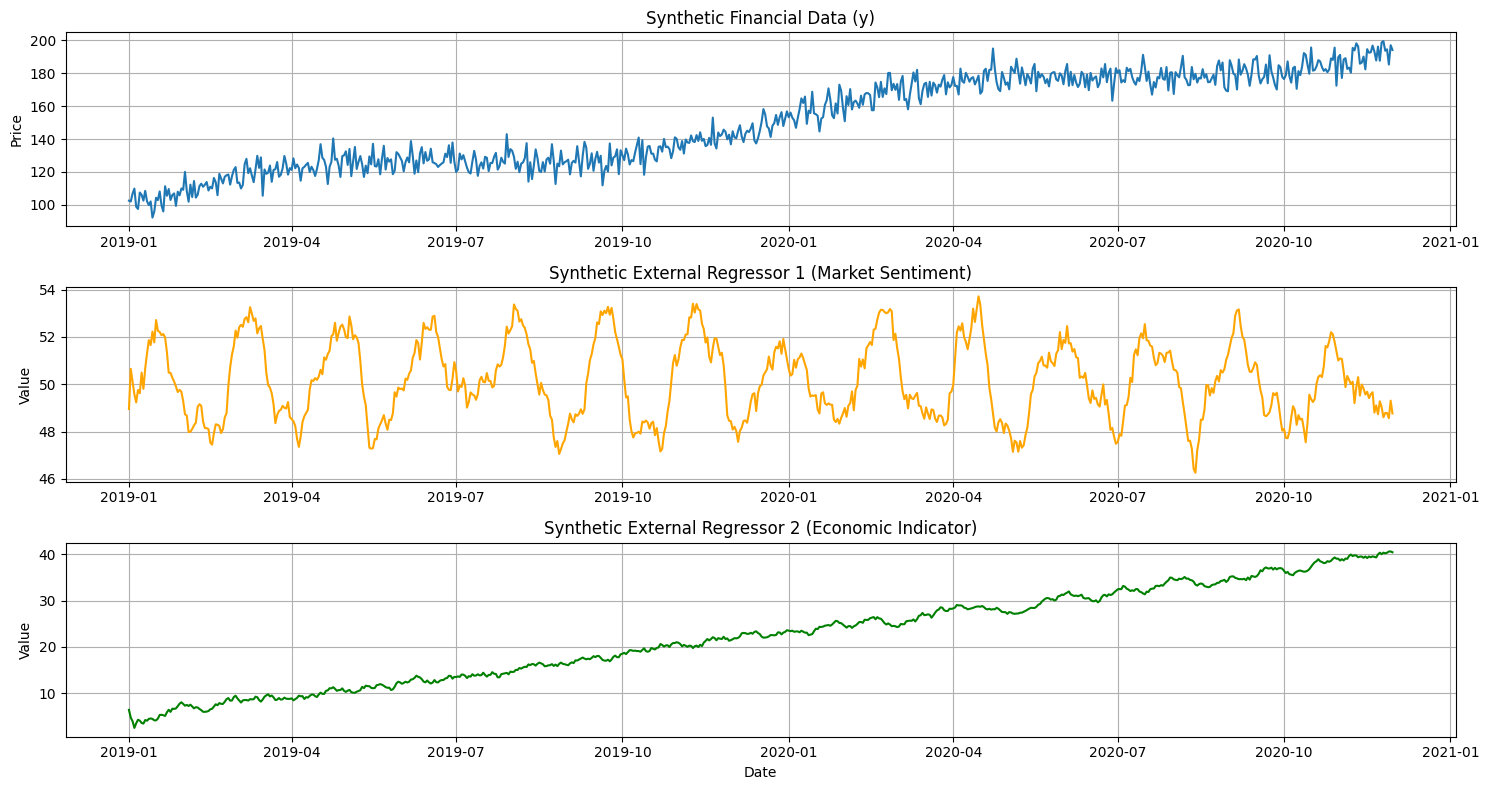

In [17]:
# 2.2. Generate Synthetic External Regressors
# Regressor 1: Market sentiment (e.g., fluctuating around a mean, with some trend)
# Let's make it slightly correlated with the main series, or at least influential.
regressor_1 = 50 + 2 * np.sin(np.linspace(0, 2 * np.pi * (n_points / 50), n_points)) + np.random.normal(0, 2, n_points)
regressor_1 = pd.Series(regressor_1).rolling(window=7, min_periods=1).mean().values # Smooth it a bit

# Regressor 2: Economic indicator (e.g., showing some volatility)
regressor_2 = 10 * np.random.rand(n_points) + 0.05 * np.arange(n_points) + np.random.normal(0, 1, n_points)
regressor_2 = pd.Series(regressor_2).rolling(window=14, min_periods=1).mean().values # Smooth it a bit

# Create the DataFrame in Prophet's required format
df = pd.DataFrame({'ds': dates, 'y': y, 'regressor_1': regressor_1, 'regressor_2': regressor_2})

# Display the first few rows and plot the data
print("Synthetic Data with Regressors:")
print(df.head())

plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.plot(df['ds'], df['y'])
plt.title('Synthetic Financial Data (y)')
plt.ylabel('Price')
plt.grid(True)


plt.subplot(3, 1, 2)
plt.plot(df['ds'], df['regressor_1'], color='orange')
plt.title('Synthetic External Regressor 1 (Market Sentiment)')
plt.ylabel('Value')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(df['ds'], df['regressor_2'], color='green')
plt.title('Synthetic External Regressor 2 (Economic Indicator)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

plt.tight_layout()
plt.show()

#3. Prepare Data for Prophet and Split into Training/Testing
Prophet doesn't require a strict y and X split like traditional ML models, as the ds and y columns are mandatory, and regressors are part of the main DataFrame. However, for evaluation, we need to split into historical data (for training) and future data (for testing/forecasting).

In [18]:
# Define the forecast horizon (how many periods into the future we want to predict)
forecast_horizon = 90 # e.g., 90 days for testing

# Split the data into training and testing sets
train_df = df.iloc[:-forecast_horizon] # All data except the last 'forecast_horizon' days
test_df = df.iloc[-forecast_horizon:]  # The last 'forecast_horizon' days for evaluation

print(f"Training data size: {len(train_df)}")
print(f"Testing data size: {len(test_df)}")

Training data size: 610
Testing data size: 90


#4. Initialize and Configure Prophet Model with Regressors
Now, we initialize the Prophet model and add our external regressors.

In [19]:
# Initialize Prophet model
# You can customize Prophet's parameters here, e.g., seasonality, changepoints
# For example, adding specific seasonality components:
model = Prophet(
    yearly_seasonality=True,     # Enable yearly seasonality
    weekly_seasonality=True,     # Enable weekly seasonality
    daily_seasonality=False,     # Daily seasonality might not be needed for daily data unless there are intra-day patterns
    seasonality_mode='additive', # Or 'multiplicative' for growth-proportional seasonality
    changepoint_prior_scale=0.05 # Adjust flexibility of trend changes (default 0.05)
)

# Add the external regressors
# Use add_regressor() for each external variable.
# You can specify mode='additive' or 'multiplicative' for each regressor.
# For simplicity, we'll use additive here.
model.add_regressor('regressor_1', prior_scale=0.5) # prior_scale controls flexibility of the regressor's impact
model.add_regressor('regressor_2', prior_scale=0.5)

# Fit the model to the training data
print("\nFitting Prophet model...")
model.fit(train_df)
print("Model fitting complete.")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpk1czfxgz/yz3grdec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk1czfxgz/0ixr7w0t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31283', 'data', 'file=/tmp/tmpk1czfxgz/yz3grdec.json', 'init=/tmp/tmpk1czfxgz/0ixr7w0t.json', 'output', 'file=/tmp/tmpk1czfxgz/prophet_model9nodofhb/prophet_model-20250610115657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:56:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Fitting Prophet model...
Model fitting complete.


#5. Make Future Predictions
To make predictions, you need a future DataFrame that extends beyond your historical data and includes the future values of your external regressors.

In [20]:
# Create a DataFrame for future predictions
# This DataFrame must have 'ds' column for future dates and
# columns for all external regressors ('regressor_1', 'regressor_2') for the forecast period.
future_dates = model.make_future_dataframe(periods=forecast_horizon, freq='D', include_history=False)
# include_history=False means it only creates dates for the future period, not including training dates.
# If you want to include history for plotting purposes, set it to True.

# Merge the future dates with the actual regressor values from the test set
# In a real-world scenario, you would need to forecast these regressors or have their known future values.
future_df = pd.merge(future_dates, test_df[['ds', 'regressor_1', 'regressor_2']], on='ds', how='left')

# Ensure all regressors are present in the future_df
if future_df['regressor_1'].isnull().any() or future_df['regressor_2'].isnull().any():
    print("Warning: Missing regressor values in future_df. This should not happen if merge is correct.")
    # For a real scenario, you'd handle how to get future regressor values (e.g., forecasting them).

# Make the forecast
print("\nGenerating forecast...")
forecast = model.predict(future_df)
print("Forecast complete.")

# Display the forecast structure
print("\nForecast DataFrame head:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())


Generating forecast...
Forecast complete.

Forecast DataFrame head:
          ds        yhat  yhat_lower  yhat_upper
0 2020-09-02  181.704583  175.443924  187.569757
1 2020-09-03  180.346374  174.066786  186.575057
2 2020-09-04  179.201401  172.521303  185.307606
3 2020-09-05  176.287868  169.959687  182.531026
4 2020-09-06  176.347011  170.540835  182.173335


#6. Evaluate the Forecast and Visualize Results
Finally, we evaluate how well the model performed on the test set and visualize the actual vs. predicted values.


Root Mean Squared Error (RMSE): 5.464
Mean Absolute Error (MAE): 4.280


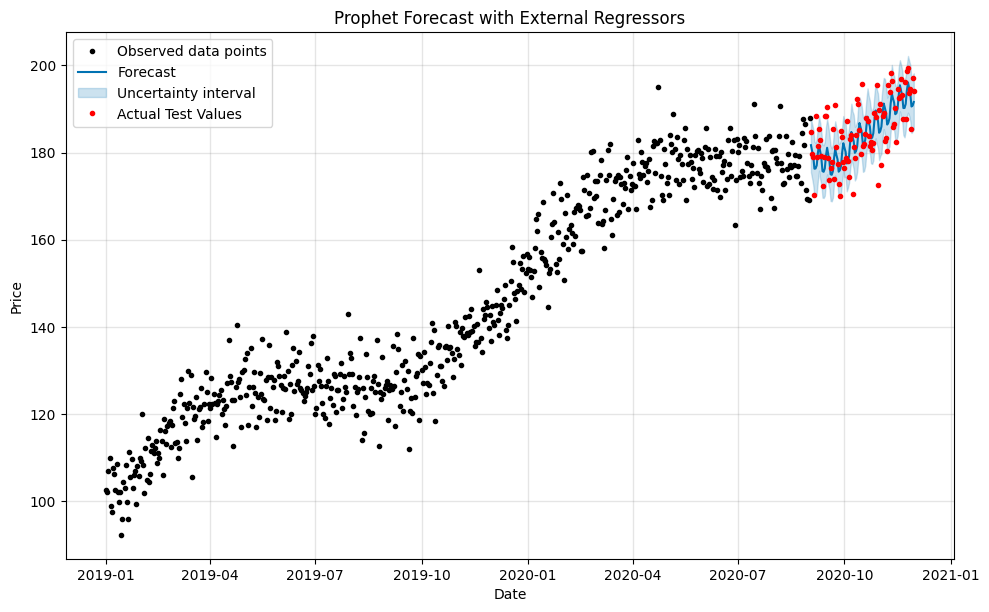

In [21]:
# Align forecast with actual test values
# Ensure 'ds' column is the index for easy comparison
actual_values = test_df.set_index('ds')['y']
predicted_values = forecast.set_index('ds')['yhat']

# Remove any dates from forecast that are not in actual_values (if any mismatch)
common_dates = actual_values.index.intersection(predicted_values.index)
actual_values_aligned = actual_values.loc[common_dates]
predicted_values_aligned = predicted_values.loc[common_dates]

# Calculate evaluation metrics
rmse = sqrt(mean_squared_error(actual_values_aligned, predicted_values_aligned))
mae = mean_absolute_error(actual_values_aligned, predicted_values_aligned)

print(f'\nRoot Mean Squared Error (RMSE): {rmse:.3f}')
print(f'Mean Absolute Error (MAE): {mae:.3f}')

# Plot the forecast
fig = model.plot(forecast) # Prophet's built-in plot function plots the forecast (yhat) with confidence intervals.
plt.plot(test_df['ds'], test_df['y'], 'r.', label='Actual Test Values') # Plot actual test values as red dots.
plt.title('Prophet Forecast with External Regressors')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


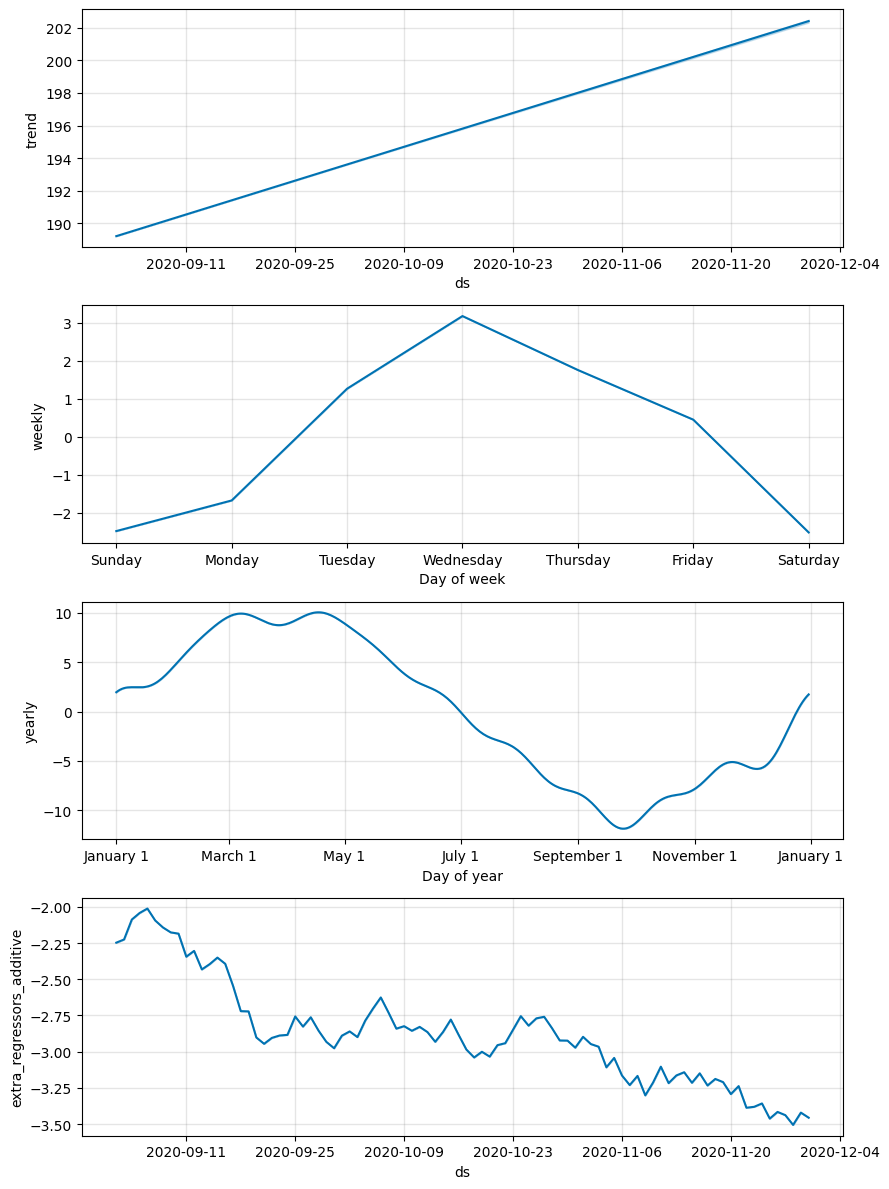

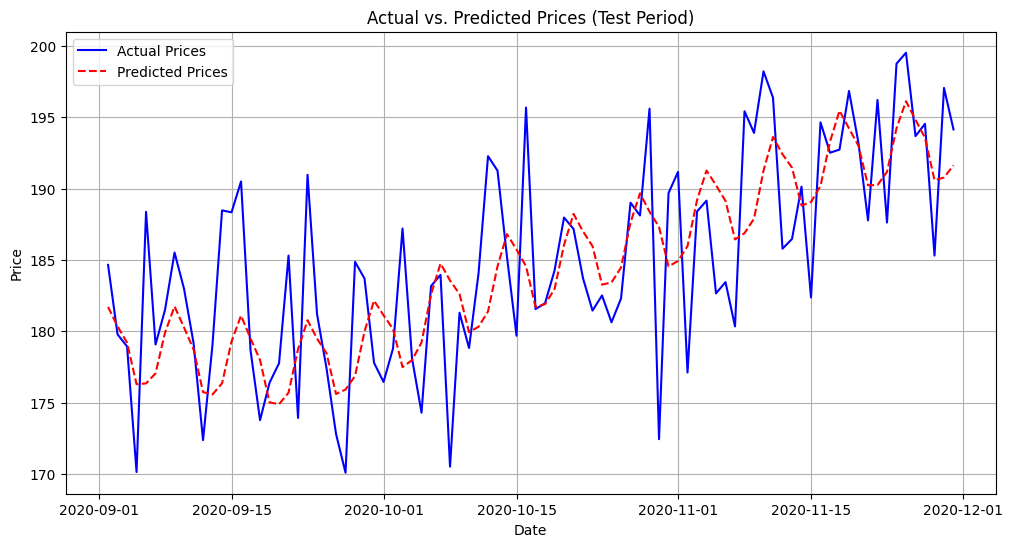

In [22]:

# Plot the forecast components
# This is very useful to understand the contribution of trend, seasonality, and regressors.
fig2 = model.plot_components(forecast)
plt.show()

# Plot actual vs. predicted for the test period only for clearer comparison
plt.figure(figsize=(12, 6))
plt.plot(actual_values_aligned.index, actual_values_aligned.values, label='Actual Prices', color='blue')
plt.plot(predicted_values_aligned.index, predicted_values_aligned.values, label='Predicted Prices', color='red', linestyle='--')
plt.title('Actual vs. Predicted Prices (Test Period)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()